# Notebooks for Introductory Overview of PyMC  

https://docs.pymc.io/en/latest/learn/examples/pymc_overview.html  
Jupyter Notebook: https://github.com/pymc-devs/pymc/blob/main/docs/source/learn/examples/pymc_overview.ipynb

### A Motivating Example: Linear Regression  

To introduce model definition, fitting, and posterior analysis, we first consider a simple Bayesian linear regression model with normal priors for the parameters. We are interested in predicting outcomes 
$Y$ as normally-distributed observations with an expected value $\mu$ that is a linear function of two predictor variables, $X_1$ and $X_2$  

$Y \sim \mathcal{N}(\mu, \sigma^2)$  
$\mu = \alpha + \beta_1 X_1 + \beta_2 X_2$  

where $\alpha$ is the intercept, and $\beta_i$ is the coefficient for covariate $X_i$, while 
$\sigma$ represents the observation error. Since we are constructing a Bayesian model, we must assign a prior distribution to the unknown variables in the model. We choose zero-mean normal priors with variance of 100 for both regression coefficients, which corresponds to weak information regarding the true parameter values. We choose a half-normal distribution (normal distribution bounded at zero) as the prior for $\sigma$.  

$$
\alpha \sim \mathcal{N}(0, 100)\\  
\beta_i \sim \mathcal{N}(0, 100)\\  
\sigma \sim |\mathcal{N}(0, 1)|  
$$


In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [5]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [6]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

Here is what the simulated data look like. We use the pylab module from the plotting library matplotlib.

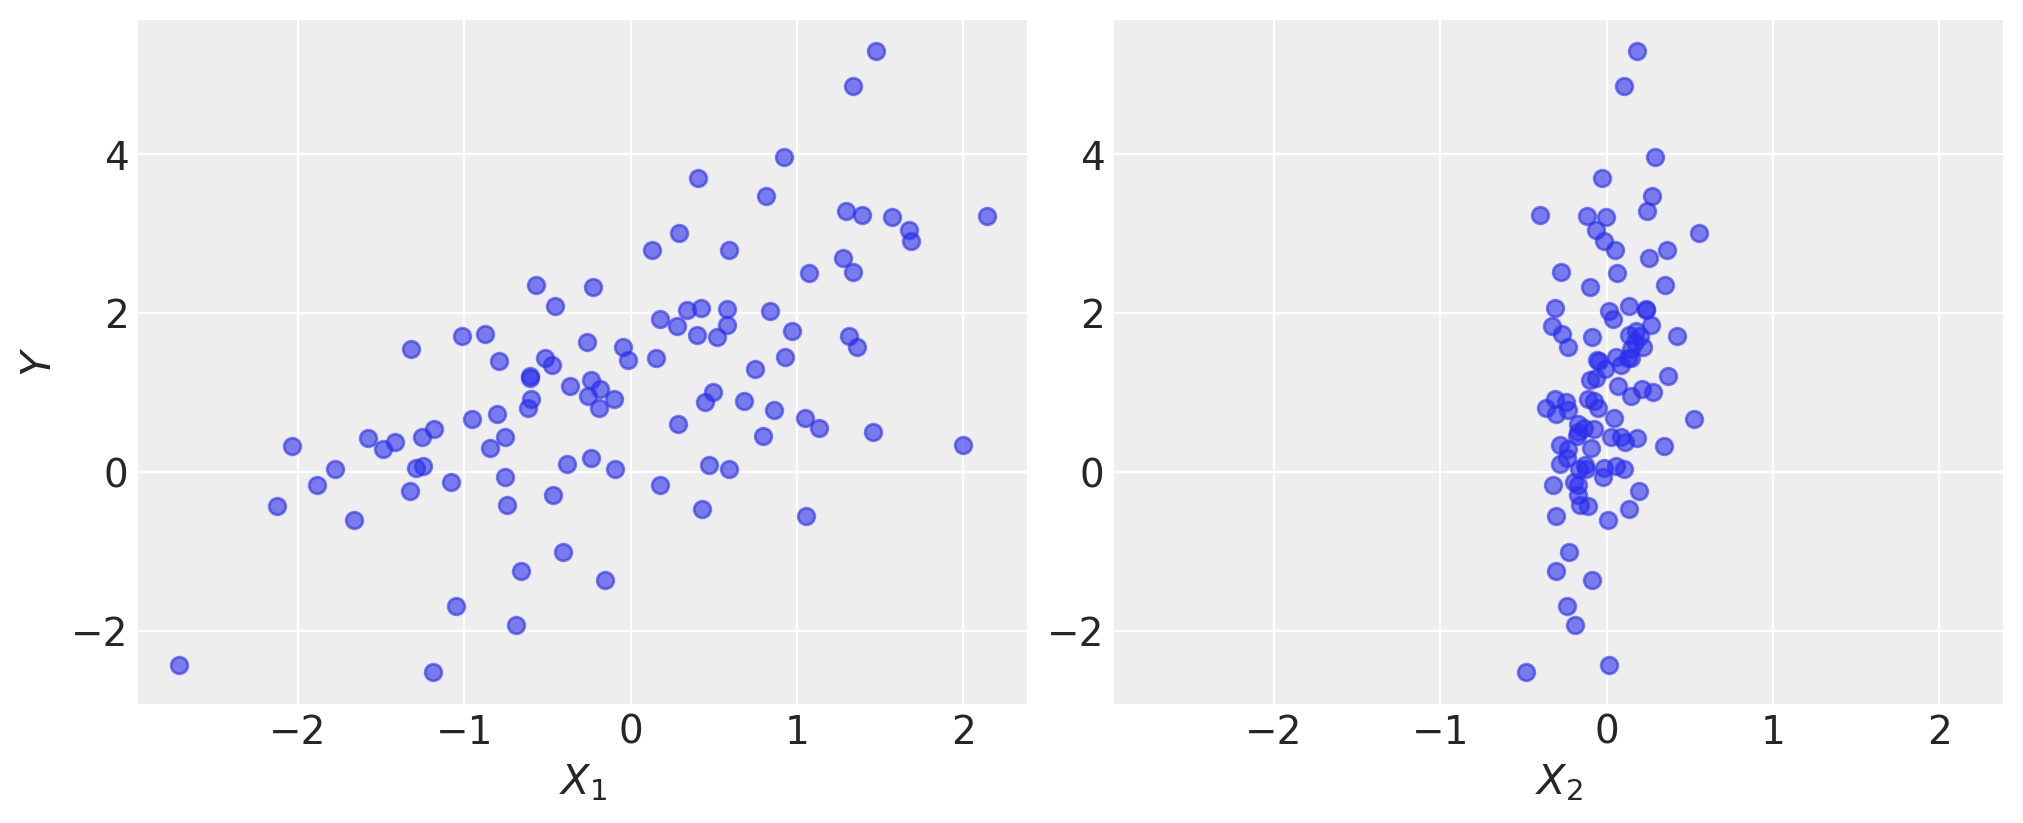

In [7]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("$Y$")
axes[0].set_xlabel("$X_1$")
axes[1].set_xlabel("$X_2$");

In [8]:
import pymc3 as pm  # AZ: I import pymc3 instead of pymc

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v3.11.2


Now we build our model, which we will present in full first, then explain each part line-by-line.

In [9]:
basic_model = pm.Model()  # a Model object is a container for the model random variables

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)  # NB: shape=2 fills two betas
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

Following instantiation of the model, the subsequent specification of the model components is performed inside a <span style="color:red">with</span> statement:  

<span style="color:green">with</span> basic_model:  

This creates a <span style="color:green">context manager</span>, with our <span style="color:red">basic_model</span> as the context, that includes all statements until the indented block ends. This means all PyMC objects introduced in the indented code block below the <span style="color:red">with</span> statement are <span style="color:green">*added to the model*</span> behind the scenes. Absent this context manager idiom, we would be forced to manually associate each of the variables with <span style="color:red">basic_model</span> right after we create them. If you try to create a new random variable without a <span style="color:red">with model:</span> statement, it will raise an error since there is no obvious model for the variable to be added to.

The first three statements in the context manager:  

alpha = pm.Normal('alpha', mu=0, sigma=10)  
beta = pm.Normal('beta', mu=0, sigma=10, shape=2)  
sigma = pm.HalfNormal('sigma', sigma=1)  

create __stochastic__ random variables with Normal prior distributions for the regression coefficients with a mean of 0 and standard deviation of 10, and a half-normal distribution for the standard deviation of the observations, $\sigma$. These are stochastic because their values are partly determined by its parents in the dependency graph of random variables, which for priors are simple constants, and <span style="color:green">partly random</span> (or <span style="color:green">stochastic</span>).

We call the <span style="color:red">pm.Normal</span> constructor to create a random variable to use as a normal prior. The first argument is always the _name_ of the random variable, which should almost always match the name of the Python variable being assigned to, since it is sometimes used to retrieve the variable from the model for summarizing output. The remaining required arguments for a stochastic object are the parameters, in this case <span style="color:red">mu</span>, the mean, and <span style="color:red">sd</span>, the standard deviation, which we assign hyperparameter values for the model. In general, a distribution’s parameters are values that determine the location, shape or scale of the random variable, depending on the parameterization of the distribution. Most commonly-used distributions, such as <span style="color:red">Beta</span>, <span style="color:red">Exponential</span>, <span style="color:red">Categorical</span>, <span style="color:red">Gamma</span>, <span style="color:red">Binomial</span> and many others, are available in PyMC.

The <span style="color:red">beta</span> variable has an additional <span style="color:red">shape</span> argument to denote it as a vector-valued parameter of size 2. The <span style="color:red">shape</span> argument is available for all distributions and specifies the length or shape of the random variable, but is optional for scalar variables, since it defaults to a value of one. It can be an integer, to specify an array, or a tuple, to specify a multidimensional array (e.g. <span style="color:red">shape=(5,7)</span> makes random variable that takes on 5 by 7 matrix values).

Detailed notes about distributions, sampling methods and other PyMC functions are available in the <span style="color:blue">API documentation</span> https://docs.pymc.io/en/latest/api.html#api.

Having defined the priors, the next statement creates the expected value <span style="color:red">mu</span> of the outcomes, specifying the linear relationship:  

mu = alpha + beta[0]*X1 + beta[1]*X2  

This creates a __deterministic__ random variable, which implies that its value is completely determined by its parents’ values. That is, there is no uncertainty beyond that which is inherent in the parents’ values. Here, <span style="color:red">mu</span> is just the sum of the intercept <span style="color:red">alpha</span> and the two products of the coefficients in <span style="color:red">beta</span> and the predictor variables, whatever their values may be.

PyMC random variables and data can be arbitrarily added, subtracted, divided, multiplied together and indexed-into to create new random variables. This allows for great model expressivity. Many common mathematical functions like <span style="color:red">sum</span>, <span style="color:red">sin</span>, <span style="color:red">exp</span> and linear algebra functions like <span style="color:red">dot</span> (for inner product) and <span style="color:red">inv</span> (for inverse) are also provided.

The final line of the model, defines <span style="color:red">Y_obs</span>, the sampling distribution of the outcomes in the dataset.  

Y_obs = Normal('Y_obs', mu=mu, sigma=sigma, observed=Y)  

This is a special case of a stochastic variable that we call an __observed stochastic__, and represents the data likelihood of the model. It is identical to a standard stochastic, except that its <span style="color:red">observed</span> argument, which passes the data to the variable, indicates that the values for this variable were observed, and should not be changed by any fitting algorithm applied to the model. The data can be passed in the form of either a <span style="color:blue">ndarray</span> or <span style="color:blue">DataFrame</span> object.

Notice that, unlike for the priors of the model, the parameters for the normal distribution of <span style="color:red">Y_obs</span> are not fixed values, but rather are the deterministic object <span style="color:red">mu</span> and the stochastic <span style="color:red">sigma</span>. This creates parent-child relationships between the likelihood and these two variables.

In [11]:
# AZ: look below for my particular version of PyMC
# ------------------------------------------------

# that works different in my version 3 of PyMC and in version 4 that in use for this tutorial
# See the modified cell below

with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

/var/folders/vm/slnjj_9x4dn3sr2lkc5h687c0000gn/T/ipykernel_31419/170420598.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  idata = pm.sample()
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 18 seconds.


The <span style="color:red">sample</span> function runs the step method(s) assigned (or passed) to it for the given number of iterations and returns an <span style="color:blue">InferenceData</span> object containing the samples collected, along with other useful attributes like statistics of the sampling run and a copy of the observed data. Notice that <span style="color:red">sample</span> generated a set of parallel chains, depending on how many compute cores are on your machine.

In [10]:
idata

<MultiTrace: 4 chains, 1000 iterations, 4 variables>

In [13]:
# AZ: run this for my version of PyMC
# -----------------------------------

with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample(return_inferencedata=True)  # AZ: I provided explicit parameter return_inferencedata

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [14]:
idata

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

The various attributes of the <span style="color:red">InferenceData</span> object can be queried in a similar way to a <span style="color:red">dict</span> containing a map from variable names to <span style="color:red">numpy.arrays</span>. For example, we can retrieve the sampling trace from the <span style="color:red">alpha</span> latent variable by using the variable name as an index to the <span style="color:red">idata.posterior</span> attribute. The first dimension of the returned array is the chain index, the second dimension is the sampling index, while the later dimensions match the shape of the variable. We can see the first 5 values for the <span style="color:red">alpha</span> variable in each chain as follows:

In [18]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)>
array([[1.12552808, 1.13106268, 1.27488142, 1.21046834, 1.21859437],
       [1.25960401, 1.25960401, 1.04304107, 1.23522007, 1.23522007],
       [1.08437533, 1.22398069, 1.23250512, 1.25771752, 1.13459951],
       [1.20433726, 1.18072574, 1.17182961, 1.27004896, 1.08912953]])
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4

If we wanted to use the slice sampling algorithm to <span style="color:red">sigma</span> instead of NUTS (which was assigned automatically), we could have specified this as the <span style="color:red">step</span> argument for <span style="color:red">sample</span>.

In [15]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step, return_inferencedata=True)  # AZ: added return_inferencedata

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 26 seconds.


## Posterior analysis

<span style="color:red">PyMC</span>’s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named <span style="color:blue">ArviZ</span>. A simple posterior plot can be created using <span style="color:red">plot_trace</span>.

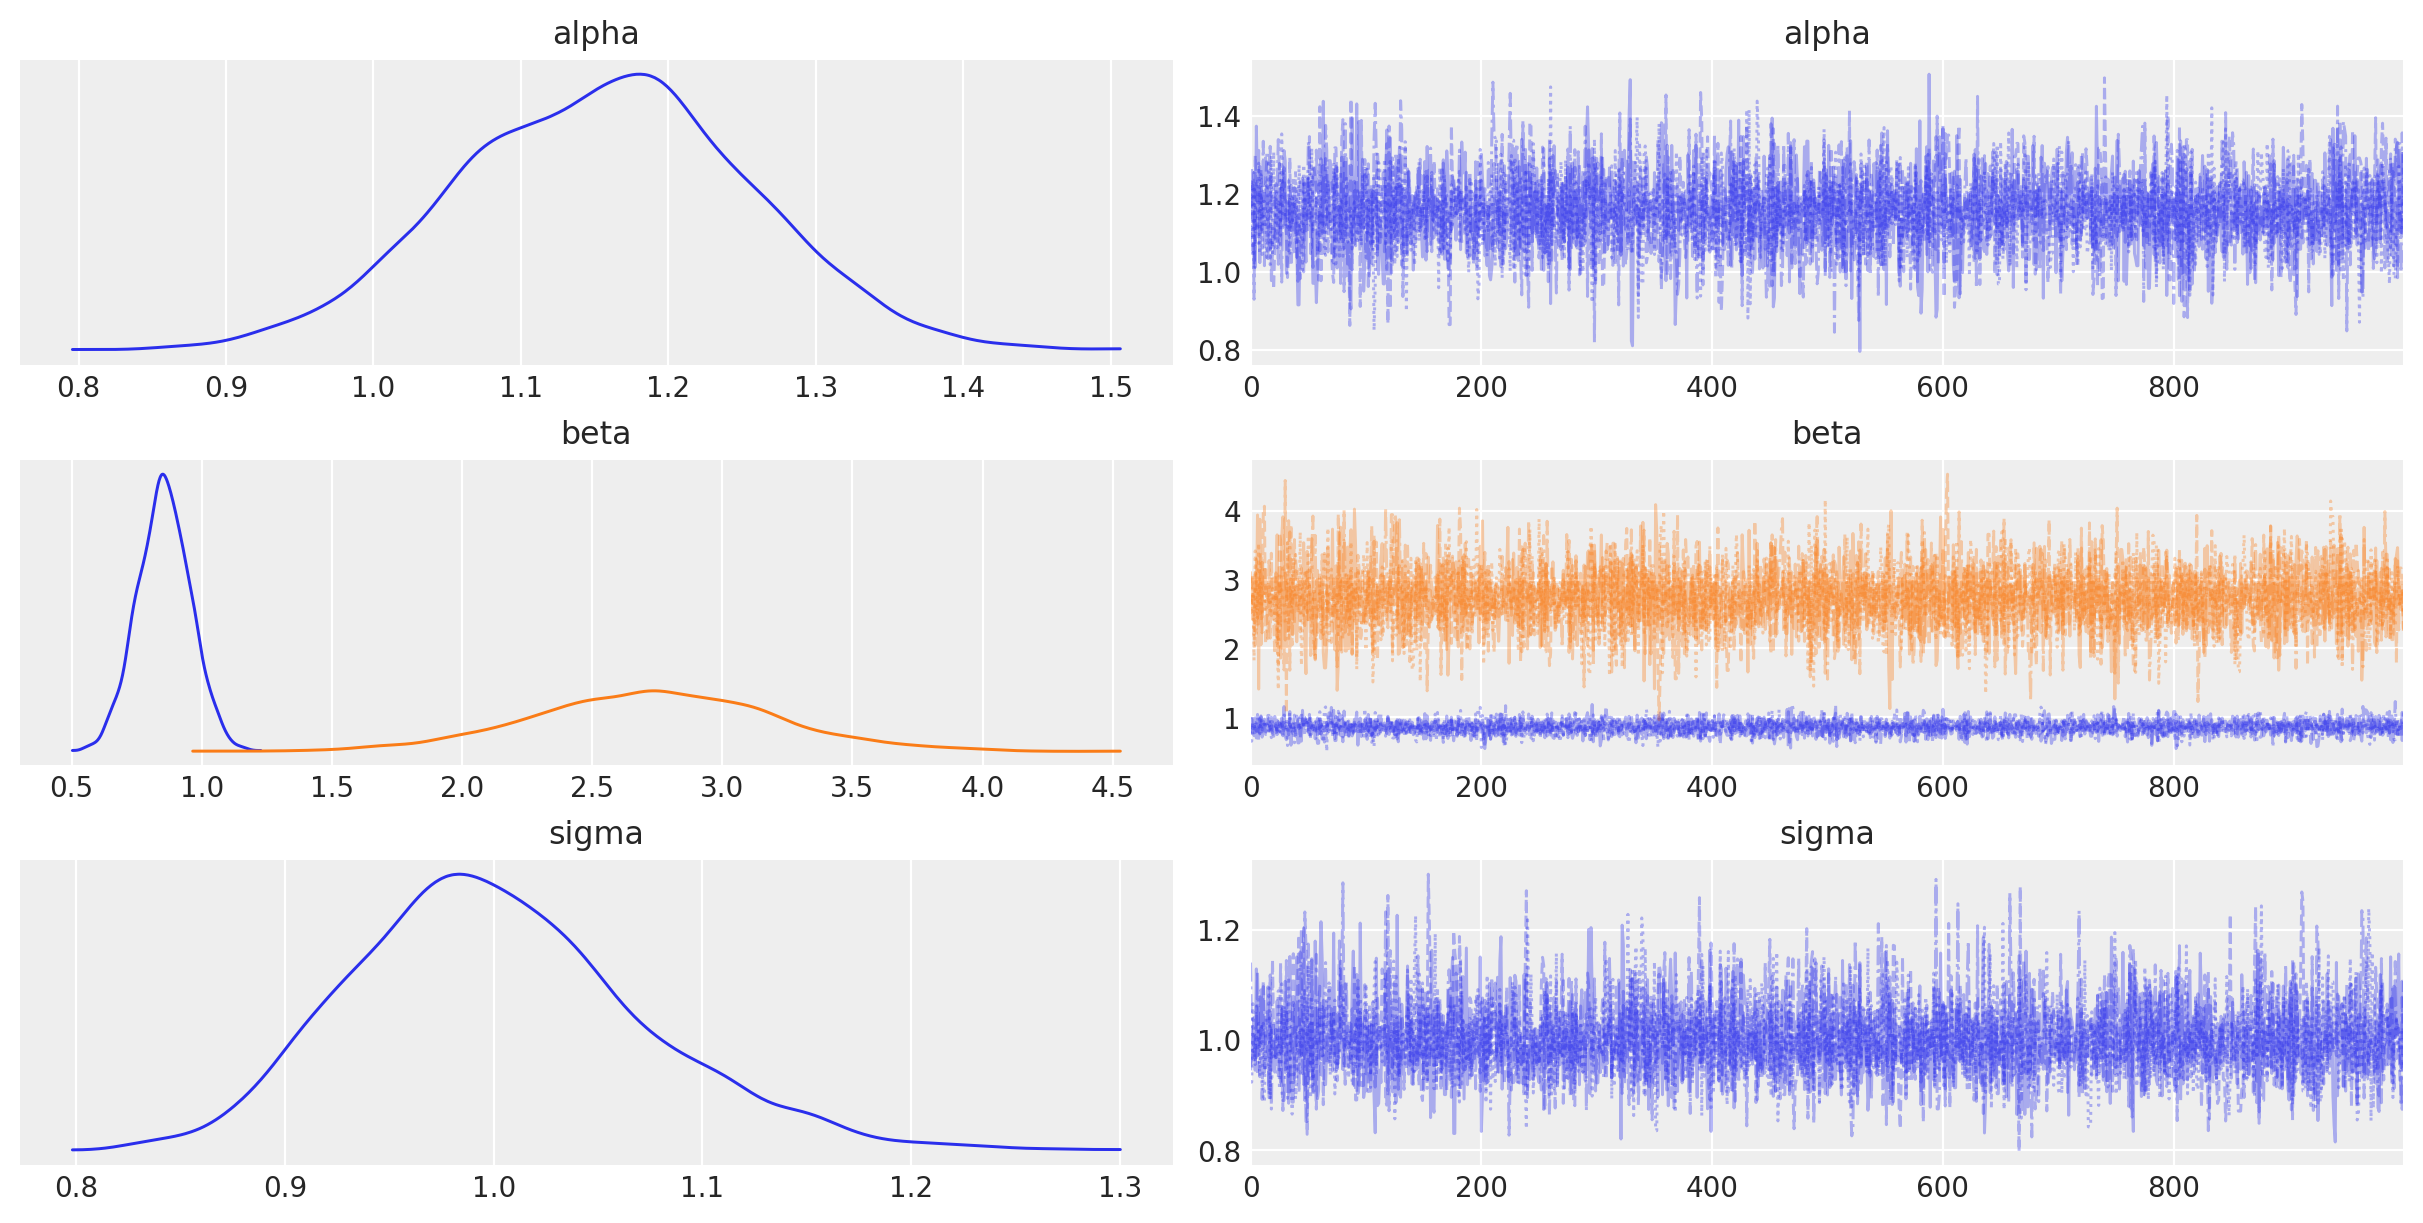

In [16]:
az.plot_trace(idata, combined=True);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The <span style="color:red">beta</span> variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

In addition, the <span style="color:red">summary</span> function provides a text-based output of common posterior statistics:

In [17]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.16,0.10,0.97,1.34,0.00,0.0,4602.10,2405.26,1.0
beta[0],0.86,0.10,0.67,1.06,0.00,0.0,6321.94,3020.28,1.0
beta[1],2.73,0.47,1.90,3.66,0.01,0.0,5693.77,2920.04,1.0
sigma,1.00,0.07,0.87,1.14,0.00,0.0,5031.33,2966.62,1.0
